In [477]:
import pandas as pd
import numpy as np
from nltk.stem.snowball import SnowballStemmer
from nltk import word_tokenize
from sklearn import manifold
from scipy.sparse.linalg import svds
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import hdbscan
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import seaborn as sns
import sklearn.datasets as data
%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}
py.init_notebook_mode();

stemmer = SnowballStemmer("english");

# Data Loading and some cleaning

Most of the point of this is to play around with two algorithms. HDBScan is a state of the art unsupervised clustering algorithm that can help you segment ad-hoc data. A major problem is that it's relatively new and many people haven't really discussed it's use since the rage is all NNs, but it's a nice way to get a quick algorithm onto your data without requiring a ton of tuning. t-SNE is also another interesting algorithm that stochastically embeds high dimensional data into lower dimensions, also with minimal tuning required.

To showcase these algorithms, I'm doing some clustering on job post data to see if anything interesting comes out of these algorithms. Let's get started.

In [383]:
# Data from https://www.kaggle.com/madhab/jobposts/data
df = pd.read_csv('jobs.csv');

In [384]:
def cleaner(description):
    ### The stemmer reads the description and cleans the words
    if (type(description) == str):
        return stemmer.stem(description.lower())
    else:
        return ""
    
def cleanSeries(series):
    #runs cleaner on dataframe series
    stored = pd.Series(map(cleaner, series), index=df.index)
    return stored
    
df["cleaned"] = cleanSeries(df["JobDescription"])

Here's where things get tricky. I ran a few of these analyses to start clustering, and I noticed it clustered based on company, meaning it only grouped job posts by descriptions that mentioned the same company. I would like to group job posts by type of job only using the descriptions, so I have a quick step to get the company names from the data and remove them from the job descriptions. The finished product is a vector of word counts for each document with stop words removed.

In [385]:
#Builds words counts for cleaned descriptions

additionalSW = [item for sublist in cleanSeries(df["Company"]).map(lambda x: x.split(" ")) for item in sublist]
stopWords = ENGLISH_STOP_WORDS.union(additionalSW)

cvec = CountVectorizer(stop_words=stopWords, max_df=1.0, ngram_range=(1,2))
cvec.fit(df["cleaned"])
cvec_counts = cvec.transform(df['cleaned'])

In [423]:
cvec_counts.shape

(19001, 86418)

So the final size of the data is 19001 job descriptions, by over 80000 words in the word count vector. My first reaction is to do dimensionality reduction. Originally I would have liked to do t-SNE on just this, but I've found it doesn't work for sparse matrices like the counts matrices, and actually trying to turn this into a dense matrix is impossible since it's about 10^5 * 10^6 values, which is about 10^11 matrix elements. Whatever your number type, it won't fit into memory, so the first step is a SVD reducing the matrix to just 19000 by 256. The rows are now what I call "document signatures".

In [386]:
# Runs Tfidf on counts forming a wrapper for the document word matrix

transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(cvec_counts)
transformed_weights.shape

# The data reduction step. Run SVD on the document/word matrix to form signatures on documents and words
U, S, V = svds(transformed_weights, k=256)

In [424]:
# This is just a df for the weights that maps words to tfidf for a quick check

weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cvec.get_feature_names(), 'weight': weights})
weights_df[weights_df['term'] == "java"]

term    weight
43786  java  0.004273

Now that we have the signatures and some words are showing up that I like, I'm going to start doing t-SNE on the results. I ended up running it with a range of perplexity values just to have it in memory and play around with it, but in the charts we'll show in the future, I'm going to select one that I feel has the best groupings, mainly one with the highest perplexity.

In [406]:
# Embed the document signatures in 2D using TSNE. This doesn't really work on the groupings
#   since they're defined by the HDBScan, but is kind of nice to look at.

perplexities = range(1, 10);
tsnes = [TSNE(n_components=2, verbose=1, perplexity=2^p, n_iter=1000) for p in perplexities];
tsne_results = [tsne.fit_transform(U) for tsne in tsnes];

[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 19001 samples in 0.342s...
[t-SNE] Computed neighbors for 19001 samples in 134.253s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19001
[t-SNE] Computed conditional probabilities for sample 2000 / 19001
[t-SNE] Computed conditional probabilities for sample 3000 / 19001
[t-SNE] Computed conditional probabilities for sample 4000 / 19001
[t-SNE] Computed conditional probabilities for sample 5000 / 19001
[t-SNE] Computed conditional probabilities for sample 6000 / 19001
[t-SNE] Computed conditional probabilities for sample 7000 / 19001
[t-SNE] Computed conditional probabilities for sample 8000 / 19001
[t-SNE] Computed conditional probabilities for sample 9000 / 19001
[t-SNE] Computed conditional probabilities for sample 10000 / 19001
[t-SNE] Computed conditional probabilities for sample 11000 / 19001
[t-SNE] Computed conditional probabilities for sample 12000 / 19001
[t-SNE] Computed conditional probabilities for s

[t-SNE] Error after 1000 iterations: 1.807211
[t-SNE] Computing 13 nearest neighbors...
[t-SNE] Indexed 19001 samples in 0.264s...
[t-SNE] Computed neighbors for 19001 samples in 129.658s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19001
[t-SNE] Computed conditional probabilities for sample 2000 / 19001
[t-SNE] Computed conditional probabilities for sample 3000 / 19001
[t-SNE] Computed conditional probabilities for sample 4000 / 19001
[t-SNE] Computed conditional probabilities for sample 5000 / 19001
[t-SNE] Computed conditional probabilities for sample 6000 / 19001
[t-SNE] Computed conditional probabilities for sample 7000 / 19001
[t-SNE] Computed conditional probabilities for sample 8000 / 19001
[t-SNE] Computed conditional probabilities for sample 9000 / 19001
[t-SNE] Computed conditional probabilities for sample 10000 / 19001
[t-SNE] Computed conditional probabilities for sample 11000 / 19001
[t-SNE] Computed conditional probabilities for sample 12000 / 19001
[t

Here's the meat of the code. Doing HDBScan on the signatures to try and tease out some groupings.

In [417]:
# Cluster using hdbscan on the signatures
# clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
nns = [3,4,5];
clusterers = [hdbscan.RobustSingleLinkage(cut=0.125, k=(2**n)) for n in nns];
clusterLabels = [clusterer.fit_predict(U) for clusterer in clusterers];
#clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

#Get a quick visualization of the clustering results. This is not wildly good since
# we're taking the TSNE of the signatures, then coloring by HDBScan on the signatures
# but it may give a quick way to see how well the HDBScan is doing



And here are some pictures. The idea is that the colorings are the HDBScan on the signatures, and t-SNE is just a nice grouping algorithm already. Now we start being able to compare both algorithms and the first thing I notice is t-SNE is actually doing better groupings than the HDBScan. Everything is just one color, while in the position dimension, there's a lot of structure.

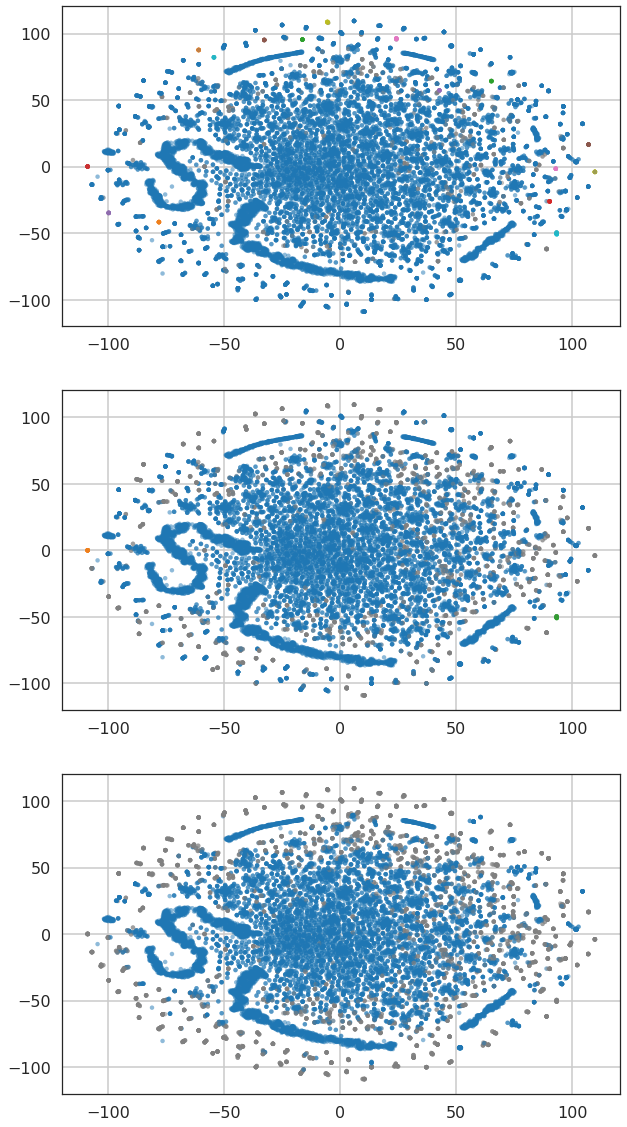

In [425]:
palette = sns.color_palette();
s = 310;
tsne = 8;
plt.figure(figsize=(10, 20))
for clusterer in clusterers:
    s+=1
    plt.subplot(s)
    cluster_colors = [sns.desaturate(palette[col % 10], 1)
        if col >= 0 else (0.5, 0.5, 0.5) for col in 
        clusterer.labels_];
    plt.scatter(tsne_results[tsne][:,0],tsne_results[tsne][:,1], c=cluster_colors, marker='.', **plot_kwds)
    plt.grid(True)
plt.show()

Instead of this, let's now use HDBScan on the t-SNE results. This may seem odd since we are essentially doing one round of data reduction, followed by another round of data reduction using a stochastic algorithm, but this actually might give some good results.

In [462]:
largeTSNE = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=1000);
ltresults = largeTSNE.fit_transform(U);

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 19001 samples in 0.304s...
[t-SNE] Computed neighbors for 19001 samples in 169.858s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19001
[t-SNE] Computed conditional probabilities for sample 2000 / 19001
[t-SNE] Computed conditional probabilities for sample 3000 / 19001
[t-SNE] Computed conditional probabilities for sample 4000 / 19001
[t-SNE] Computed conditional probabilities for sample 5000 / 19001
[t-SNE] Computed conditional probabilities for sample 6000 / 19001
[t-SNE] Computed conditional probabilities for sample 7000 / 19001
[t-SNE] Computed conditional probabilities for sample 8000 / 19001
[t-SNE] Computed conditional probabilities for sample 9000 / 19001
[t-SNE] Computed conditional probabilities for sample 10000 / 19001
[t-SNE] Computed conditional probabilities for sample 11000 / 19001
[t-SNE] Computed conditional probabilities for sample 12000 / 19001
[t-SNE] Computed conditional probabilities for 

In [495]:
tsneResultsClusterer = hdbscan.RobustSingleLinkage(cut=0.125, k=4);
tsneResultsClusterer.fit_predict(ltresults);

In [509]:
cluster_colors = [palette[col % 10]
        if col >= 0 else (0.5, 0.5, 0.5) for col in 
        tsneResultsClusterer.labels_];

trace = go.Scatter3d(
    x=ltresults[:,0],
    y=ltresults[:,1],
    z=ltresults[:,2],
    mode='markers',
    marker=dict(
        color=cluster_colors,
        colorscale='Viridis',
        size=2,
        symbol='circle',
        opacity=0.9
    )
)
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)